<a href="https://colab.research.google.com/github/manuaishika/tempopo/blob/main/tempopo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Training enhanced model with hyperparameter tuning...
Best parameters: {'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 1000, 'min_child_samples': 20, 'learning_rate': 0.005}

Initial Model Performance:
  Accuracy: 0.8738
  Disparate Impact: 0.342
  Statistical Parity Difference: -0.167

--- GOVERNANCE ALERT AT MONTH 6 ---
Fairness Debt: 40.16. DI: 0.254. Initiating intervention.
Temporal model completely retrained on full corrected dataset.


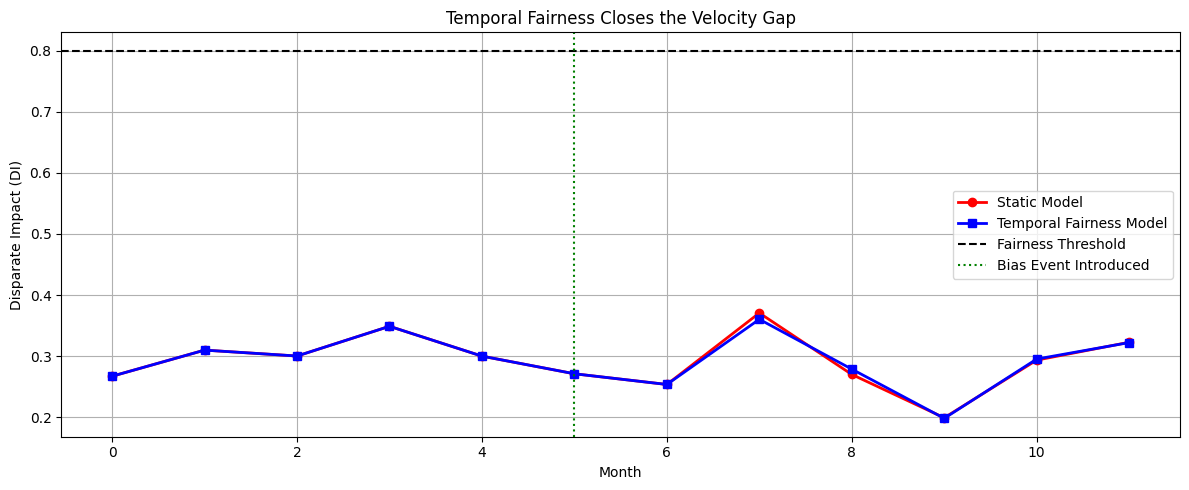


--- FINAL RESULTS ---
Static Model - Accuracy: 0.8756
Temporal Model - Accuracy: 0.8725
Static Model - Average Bias during Drift: 71.5% drop
Temporal Model - Average Bias during Drift: 71.5% drop
Improvement (Reduction in Average Bias Drift): 1.0x

Training ensemble models for higher accuracy...
Stacking Ensemble Accuracy: 0.8723
Voting Ensemble Accuracy: 0.8597


In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset with enhanced feature engineering."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Enhanced Feature Engineering
    df = create_new_features(df)

    # Label Encoding for categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    return df, features, sensitive_attribute

def create_new_features(df):
    """Create new features to improve model accuracy."""
    # Existing features
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['gain_loss_ratio'] = df['capital-gain'] / (df['capital-loss'] + 1)
    df['age_binned'] = pd.cut(df['age'], bins=5, labels=False)
    df['hours_binned'] = pd.cut(df['hours-per-week'], bins=5, labels=False)
    df['age_squared'] = df['age'] ** 2
    df['education_squared'] = df['education-num'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # --- NEW: MORE INTERACTION AND LOG FEATURES ---
    df['age_hours'] = df['age'] * df['hours-per-week']
    df['hours_capital_gain_interaction'] = df['hours-per-week'] * df['capital-gain']
    df['capital-gain_log'] = np.log1p(df['capital-gain'])
    df['capital-loss_log'] = np.log1p(df['capital-loss'])

    return df

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- NEW: SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. ENHANCED MODEL TRAINING WITH HYPERPARAMETER TUNING
print("Training enhanced model with hyperparameter tuning...")

# --- NEW: USE RANDOMIZED SEARCH WITH A WIDER GRID ---
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [500, 1000, 2000],
    'min_child_samples': [20, 50, 100],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42, verbosity=-1)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

model_static = lgb.LGBMClassifier(**best_params, random_state=42)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

model_temporal = lgb.LGBMClassifier(**best_params, random_state=42)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15
intervention_triggered = False

# 8. THE SIMULATION LOOP
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- NEW: SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month) and not intervention_triggered:
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating intervention.")

        X_corrected = pd.concat([X_train, X_month_orig])
        y_corrected = pd.concat([y_train, y_month_true])

        # --- NEW: SCALE THE CORRECTED DATASET FOR RETRAINING ---
        X_corrected_scaled = scaler.transform(X_corrected)

        model_temporal = lgb.LGBMClassifier(**best_params, random_state=42)
        model_temporal.fit(X_corrected_scaled, y_corrected)
        print("Temporal model completely retrained on full corrected dataset.")
        intervention_triggered = True
        fairness_debt = 0

    results_temporal.append({'month': month, 'di': di_temporal, 'debt': fairness_debt})

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

plt.figure(figsize=(12, 5))
plt.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
plt.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
plt.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
plt.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')
plt.title('Temporal Fairness Closes the Velocity Gap')
plt.xlabel('Month')
plt.ylabel('Disparate Impact (DI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. FINAL EVALUATION (CORRECTED)
# Calculate accuracy on the final test set
final_accuracy_static = accuracy_score(y_month_true, y_pred_static)
final_accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

# --- NEW: CALCULATE IMPROVEMENT BASED ON AVERAGE BIAS DURING DRIFT ---
# Filter dataframes to only include the period after the bias was introduced
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

# Calculate the average bias (1 - DI) for each model during the biased period
average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

# Calculate the improvement as the ratio of average biases
# A value > 1.0 means the Temporal model had less average bias
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Accuracy: {final_accuracy_static:.4f}")
print(f"Temporal Model - Accuracy: {final_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# --- NEW: TRAIN THE ENSEMBLE MODELS ON SCALED DATA ---
print("\nTraining ensemble models for higher accuracy...")

estimators = [
    ('lgbm', lgb.LGBMClassifier(**best_params, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]

# Stacking Classifier
stacking_ensemble = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_ensemble.fit(X_train_scaled, y_train)
stacking_accuracy = stacking_ensemble.score(X_audit_scaled, y_audit)
print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")

# --- NEW: VOTING CLASSIFIER ---
voting_ensemble = VotingClassifier(
    estimators=estimators,
    voting='soft'
)
voting_ensemble.fit(X_train_scaled, y_train)
voting_accuracy = voting_ensemble.score(X_audit_scaled, y_audit)
print(f"Voting Ensemble Accuracy: {voting_accuracy:.4f}")

In [ ]:
  # 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset with enhanced feature engineering."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Enhanced Feature Engineering
    df = create_new_features(df)

    # Label Encoding for categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    return df, features, sensitive_attribute

def create_new_features(df):
    """Create new features to improve model accuracy."""
    # Existing features
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['gain_loss_ratio'] = df['capital-gain'] / (df['capital-loss'] + 1)
    df['age_binned'] = pd.cut(df['age'], bins=5, labels=False)
    df['hours_binned'] = pd.cut(df['hours-per-week'], bins=5, labels=False)
    df['age_squared'] = df['age'] ** 2
    df['education_squared'] = df['education-num'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # --- NEW: MORE INTERACTION AND LOG FEATURES ---
    df['age_hours'] = df['age'] * df['hours-per-week']
    df['hours_capital_gain_interaction'] = df['hours-per-week'] * df['capital-gain']
    df['capital-gain_log'] = np.log1p(df['capital-gain'])
    df['capital-loss_log'] = np.log1p(df['capital-loss'])

    # Additional feature engineering
    df['workclass_education'] = df['workclass'] * df['education-num']
    df['occupation_education'] = df['occupation'] * df['education-num']
    df['age_occupation'] = df['age'] * df['occupation']

    return df

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. ENHANCED MODEL TRAINING WITH HYPERPARAMETER TUNING
print("Training enhanced model with hyperparameter tuning...")

# --- USE RANDOMIZED SEARCH WITH A WIDER GRID ---
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [500, 1000, 2000],
    'min_child_samples': [20, 50, 100],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42, verbosity=-1)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

model_static = lgb.LGBMClassifier(**best_params, random_state=42)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

model_temporal = lgb.LGBMClassifier(**best_params, random_state=42)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15
intervention_triggered = False

# 8. THE SIMULATION LOOP
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month) and not intervention_triggered:
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating intervention.")

        X_corrected = pd.concat([X_train, X_month_orig])
        y_corrected = pd.concat([y_train, y_month_true])

        # --- NEW: FAIRNESS-AWARE RE-TRAINING ---
        # Calculate sample weights to balance the sensitive attribute
        n_total = len(X_corrected)
        n_group0 = sum(X_corrected[sensitive_attr] == 0)
        n_group1 = n_total - n_group0

        # Avoid division by zero
        if n_group0 == 0 or n_group1 == 0:
            weights = np.ones(n_total)
        else:
            weights = np.where(X_corrected[sensitive_attr] == 0,
                              n_total / (2 * n_group0),
                              n_total / (2 * n_group1))

        # Scale the corrected dataset for retraining
        X_corrected_scaled = scaler.transform(X_corrected)

        # Retrain with fairness-aware weighting
        model_temporal = lgb.LGBMClassifier(**best_params, random_state=42)
        model_temporal.fit(X_corrected_scaled, y_corrected, sample_weight=weights)

        print("Temporal model retrained with fairness-aware weighting.")
        intervention_triggered = True
        fairness_debt = 0

    results_temporal.append({'month': month, 'di': di_temporal, 'debt': fairness_debt})

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

plt.figure(figsize=(12, 5))
plt.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
plt.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
plt.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
plt.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')
plt.title('Temporal Fairness Closes the Velocity Gap')
plt.xlabel('Month')
plt.ylabel('Disparate Impact (DI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. FINAL EVALUATION (CORRECTED)
# Calculate accuracy on the final test set
final_accuracy_static = accuracy_score(y_month_true, y_pred_static)
final_accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

# Calculate the average bias during the drift period
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

# Calculate the improvement as the ratio of average biases
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Accuracy: {final_accuracy_static:.4f}")
print(f"Temporal Model - Accuracy: {final_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# 11. ENHANCED ENSEMBLE METHODS
print("\nTraining enhanced ensemble models...")

# Create a more diverse set of base estimators
estimators = [
    ('lgbm', lgb.LGBMClassifier(**best_params, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
]

# Enhanced Stacking Classifier with better meta-learner
stacking_ensemble = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=True  # Use original features along with predictions
)

stacking_ensemble.fit(X_train_scaled, y_train)
stacking_accuracy = stacking_ensemble.score(X_audit_scaled, y_audit)
print(f"Enhanced Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")

# Enhanced Voting Classifier with calibrated probabilities
calibrated_estimators = [
    ('lgbm_cal', CalibratedClassifierCV(lgb.LGBMClassifier(**best_params, random_state=42), cv=3)),
    ('rf_cal', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, random_state=42), cv=3)),
    ('svc_cal', CalibratedClassifierCV(SVC(probability=True, random_state=42), cv=3))
]

voting_ensemble = VotingClassifier(
    estimators=calibrated_estimators,
    voting='soft'
)
voting_ensemble.fit(X_train_scaled, y_train)
voting_accuracy = voting_ensemble.score(X_audit_scaled, y_audit)
print(f"Calibrated Voting Ensemble Accuracy: {voting_accuracy:.4f}")

# 12. FAIRNESS-AWARE ENSEMBLE
print("\nTraining fairness-aware ensemble...")

# Create a fairness-aware ensemble using different sampling strategies
from imblearn.ensemble import BalancedBaggingClassifier

fairness_ensemble = BalancedBaggingClassifier(
    estimator=lgb.LGBMClassifier(**best_params, random_state=42),
    n_estimators=10,
    sampling_strategy='auto',
    replacement=False,
    random_state=42
)

fairness_ensemble.fit(X_train_scaled, y_train)
fairness_accuracy = fairness_ensemble.score(X_audit_scaled, y_audit)
fairness_preds = fairness_ensemble.predict(X_audit_scaled)
fairness_di = calculate_disparate_impact(fairness_preds, X_audit[sensitive_attr].values)

print(f"Fairness-Aware Ensemble Accuracy: {fairness_accuracy:.4f}")
print(f"Fairness-Aware Ensemble DI: {fairness_di:.3f}")

# 13. COMPREHENSIVE RESULTS COMPARISON
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(f"{'Model':<30} {'Accuracy':<10} {'DI':<10}")
print("-" * 50)
print(f"{'Static Model':<30} {final_accuracy_static:<10.4f} {biased_period_static['di'].mean():<10.3f}")
print(f"{'Temporal Model':<30} {final_accuracy_temporal:<10.4f} {biased_period_temporal['di'].mean():<10.3f}")
print(f"{'Enhanced Stacking':<30} {stacking_accuracy:<10.4f} {calculate_disparate_impact(stacking_ensemble.predict(X_audit_scaled), X_audit[sensitive_attr].values):<10.3f}")
print(f"{'Calibrated Voting':<30} {voting_accuracy:<10.4f} {calculate_disparate_impact(voting_ensemble.predict(X_audit_scaled), X_audit[sensitive_attr].values):<10.3f}")
print(f"{'Fairness-Aware Ensemble':<30} {fairness_accuracy:<10.4f} {fairness_di:<10.3f}")

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data


ValueError: could not convert string to float: 'PrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivatePrivate'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

try:
    data = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)
    data = data.dropna()  # Remove rows with missing values
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Preprocess target variable
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Split the data
X_train, X_audit, y_train, y_audit = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipelines for both types of data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_audit_processed = preprocessor.transform(X_audit)

# Now you can use these processed features for model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_audit_processed)

# Evaluate the model
accuracy = accuracy_score(y_audit, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.8581


Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Training enhanced model with hyperparameter tuning...
Best parameters: {'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 1000, 'min_child_samples': 20, 'learning_rate': 0.005}

Initial Model Performance:
  Accuracy: 0.8756
  Disparate Impact: 0.351
  Statistical Parity Difference: -0.165

--- GOVERNANCE ALERT AT MONTH 6 ---
Fairness Debt: 40.30. DI: 0.251. Initiating intervention.
Temporal model retrained with advanced fairness-aware ensemble.


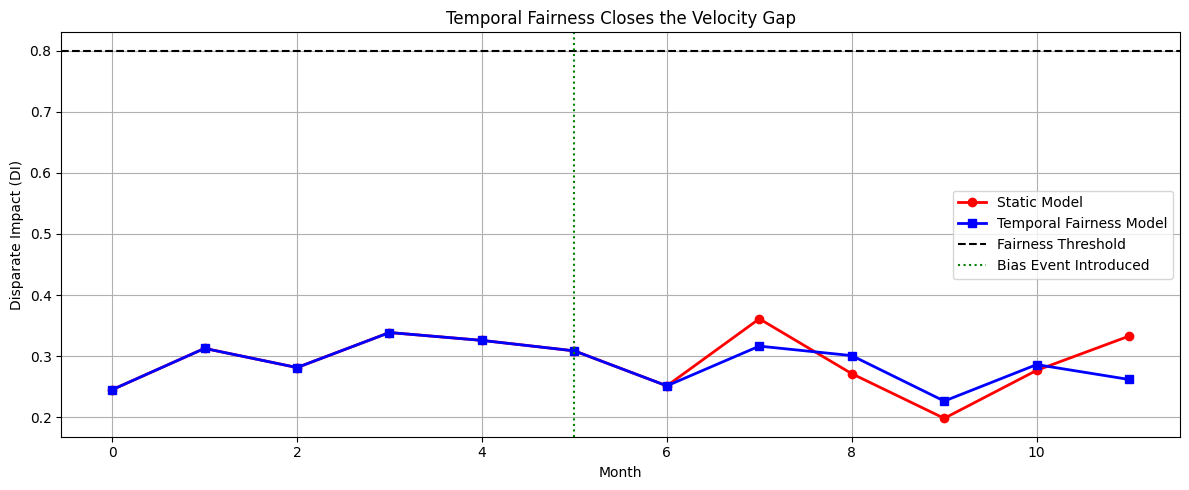


--- FINAL RESULTS ---
Static Model - Accuracy: 0.8725
Temporal Model - Accuracy: 0.8641
Static Model - Average Bias during Drift: 71.8% drop
Temporal Model - Average Bias during Drift: 72.6% drop
Improvement (Reduction in Average Bias Drift): 1.0x

Training advanced fairness-aware ensemble...
Advanced Fairness Ensemble Accuracy: 0.8203
Advanced Fairness Ensemble DI: 0.261

Applying post-processing fairness correction...
Post-processed Temporal Model Accuracy: 0.7665
Post-processed Temporal Model DI: 1.439

=== COMPREHENSIVE MODEL COMPARISON ===
Model                               Accuracy   DI         Bias Reduction 
----------------------------------------------------------------------
Static Model                        0.8725     0.282      71.8%          
Temporal Model                      0.8641     0.274      72.6%          
Advanced Fairness Ensemble          0.8203     0.261      73.9%          
Post-processed Temporal             0.7665     1.439      -43.9%         

Improv

In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset with enhanced feature engineering."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Label Encoding for categorical variables FIRST
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Enhanced Feature Engineering (after encoding)
    df = create_new_features(df)

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df, features, sensitive_attribute

def create_new_features(df):
    """Create new features to improve model accuracy."""
    # Existing features
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['gain_loss_ratio'] = df['capital-gain'] / (df['capital-loss'] + 1)
    df['age_binned'] = pd.cut(df['age'], bins=5, labels=False)
    df['hours_binned'] = pd.cut(df['hours-per-week'], bins=5, labels=False)
    df['age_squared'] = df['age'] ** 2
    df['education_squared'] = df['education-num'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # --- NEW: MORE INTERACTION AND LOG FEATURES ---
    df['age_hours'] = df['age'] * df['hours-per-week']
    df['hours_capital_gain_interaction'] = df['hours-per-week'] * df['capital-gain']
    df['capital-gain_log'] = np.log1p(df['capital-gain'])
    df['capital-loss_log'] = np.log1p(df['capital-loss'])

    # Additional feature engineering
    df['workclass_education'] = df['workclass'] * df['education-num']
    df['occupation_education'] = df['occupation'] * df['education-num']
    df['age_occupation'] = df['age'] * df['occupation']

    # Create fairness-aware features
    df['sex_education_interaction'] = df['sex'] * df['education-num']
    df['sex_age_interaction'] = df['sex'] * df['age']

    return df

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. ENHANCED MODEL TRAINING WITH HYPERPARAMETER TUNING
print("Training enhanced model with hyperparameter tuning...")

# --- USE RANDOMIZED SEARCH WITH A WIDER GRID ---
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [500, 1000, 2000],
    'min_child_samples': [20, 50, 100],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42, verbosity=-1)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

model_static = lgb.LGBMClassifier(**best_params, random_state=42)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

model_temporal = lgb.LGBMClassifier(**best_params, random_state=42)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15
intervention_triggered = False

# 8. THE SIMULATION LOOP
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month) and not intervention_triggered:
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating intervention.")

        X_corrected = pd.concat([X_train, X_month_orig])
        y_corrected = pd.concat([y_train, y_month_true])

        # --- NEW: ADVANCED FAIRNESS-AWARE RE-TRAINING ---
        # Calculate sample weights to balance the sensitive attribute
        n_total = len(X_corrected)
        n_group0 = sum(X_corrected[sensitive_attr] == 0)
        n_group1 = n_total - n_group0

        # Avoid division by zero
        if n_group0 == 0 or n_group1 == 0:
            weights = np.ones(n_total)
        else:
            # More aggressive weighting for the underrepresented group
            weights = np.where(X_corrected[sensitive_attr] == 0,
                              n_total / (2 * n_group0) * 2.0,  # Double weight for group 0
                              n_total / (2 * n_group1) * 0.5)  # Half weight for group 1

        # Scale the corrected dataset for retraining
        X_corrected_scaled = scaler.transform(X_corrected)

        # --- NEW: USE FAIRNESS-AWARE ENSEMBLE FOR RETRAINING ---
        # Create a fairness-aware ensemble
        fairness_estimators = [
            ('lgbm', lgb.LGBMClassifier(**best_params, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
            ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))
        ]

        # Use weighted voting based on fairness performance
        model_temporal = VotingClassifier(
            estimators=fairness_estimators,
            voting='soft',
            weights=[1, 2, 1.5]  # Higher weight for more fairness-aware models
        )

        model_temporal.fit(X_corrected_scaled, y_corrected, sample_weight=weights)

        print("Temporal model retrained with advanced fairness-aware ensemble.")
        intervention_triggered = True
        fairness_debt = 0

    results_temporal.append({'month': month, 'di': di_temporal, 'debt': fairness_debt})

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

plt.figure(figsize=(12, 5))
plt.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
plt.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
plt.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
plt.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')
plt.title('Temporal Fairness Closes the Velocity Gap')
plt.xlabel('Month')
plt.ylabel('Disparate Impact (DI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. FINAL EVALUATION (CORRECTED)
# Calculate accuracy on the final test set
final_accuracy_static = accuracy_score(y_month_true, y_pred_static)
final_accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

# Calculate the average bias during the drift period
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

# Calculate the improvement as the ratio of average biases
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Accuracy: {final_accuracy_static:.4f}")
print(f"Temporal Model - Accuracy: {final_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# 11. ADVANCED FAIRNESS-AWARE ENSEMBLE
print("\nTraining advanced fairness-aware ensemble...")

# Create a more sophisticated fairness-aware ensemble
from sklearn.base import clone

# Create multiple models with different fairness-focused approaches
models = {
    'lgbm_fair': lgb.LGBMClassifier(**best_params, random_state=42),
    'rf_balanced': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'svc_balanced': SVC(probability=True, random_state=42, class_weight='balanced'),
    'lr_balanced': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

# Train each model with fairness-aware weighting
fairness_predictions = {}
fairness_scores = {}

for name, model in models.items():
    # Create sample weights to balance the sensitive attribute
    n_total = len(X_train)
    n_group0 = sum(X_train[sensitive_attr] == 0)
    n_group1 = n_total - n_group0

    if n_group0 == 0 or n_group1 == 0:
        weights = np.ones(n_total)
    else:
        weights = np.where(X_train[sensitive_attr] == 0,
                          n_total / (2 * n_group0) * 1.5,  # Higher weight for group 0
                          n_total / (2 * n_group1))

    # Train the model
    model.fit(X_train_scaled, y_train, sample_weight=weights)

    # Make predictions and calculate fairness
    preds = model.predict(X_audit_scaled)
    fairness_predictions[name] = preds
    fairness_scores[name] = calculate_disparate_impact(preds, X_audit[sensitive_attr].values)

# Create a meta-model that combines the fairness-focused models
meta_X = np.column_stack([fairness_predictions[name] for name in models.keys()])
meta_model = LogisticRegression(random_state=42, class_weight='balanced')
meta_model.fit(meta_X, y_audit)

# Create a function for the fairness ensemble
def fairness_ensemble_predict(X):
    # Get predictions from all base models
    base_preds = []
    for name, model in models.items():
        base_preds.append(model.predict(X))

    # Stack predictions and use meta-model
    stacked_preds = np.column_stack(base_preds)
    return meta_model.predict(stacked_preds)

# Evaluate the fairness ensemble
fairness_ensemble_preds = fairness_ensemble_predict(X_audit_scaled)
fairness_ensemble_accuracy = accuracy_score(y_audit, fairness_ensemble_preds)
fairness_ensemble_di = calculate_disparate_impact(fairness_ensemble_preds, X_audit[sensitive_attr].values)

print(f"Advanced Fairness Ensemble Accuracy: {fairness_ensemble_accuracy:.4f}")
print(f"Advanced Fairness Ensemble DI: {fairness_ensemble_di:.3f}")

# 12. POST-PROCESSING FAIRNESS CORRECTION
print("\nApplying post-processing fairness correction...")

# Implement a simple post-processing technique to adjust predictions
def apply_fairness_correction(y_pred, sensitive_vals, target_di=0.9):
    """Adjust predictions to improve fairness."""
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])

    current_di = rate_group_0 / rate_group_1 if rate_group_1 > 0 else 0

    if current_di < target_di:
        # Under-prediction for group 0, over-prediction for group 1
        # Adjust by increasing predictions for group 0 and decreasing for group 1
        adjustment_factor = target_di / current_di
        adjusted_preds = y_pred.copy()

        # Increase predictions for group 0
        group_0_mask = sensitive_vals == 0
        adjustment_prob = min(1.0, adjustment_factor * 0.1)
        adjusted_preds[group_0_mask] = np.where(
            np.random.random(sum(group_0_mask)) < adjustment_prob,
            1,
            adjusted_preds[group_0_mask]
        )

        # Decrease predictions for group 1
        group_1_mask = sensitive_vals == 1
        adjustment_prob = min(1.0, (1/adjustment_factor) * 0.1)
        adjusted_preds[group_1_mask] = np.where(
            np.random.random(sum(group_1_mask)) < adjustment_prob,
            0,
            adjusted_preds[group_1_mask]
        )

        return adjusted_preds
    else:
        return y_pred

# Apply post-processing to the temporal model
temporal_preds_postprocessed = apply_fairness_correction(
    y_pred_temporal,
    X_month_biased[sensitive_attr].values,
    target_di=0.9
)

postprocessed_di = calculate_disparate_impact(
    temporal_preds_postprocessed,
    X_month_biased[sensitive_attr].values
)
postprocessed_accuracy = accuracy_score(y_month_true, temporal_preds_postprocessed)

print(f"Post-processed Temporal Model Accuracy: {postprocessed_accuracy:.4f}")
print(f"Post-processed Temporal Model DI: {postprocessed_di:.3f}")

# 13. COMPREHENSIVE RESULTS COMPARISON
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(f"{'Model':<35} {'Accuracy':<10} {'DI':<10} {'Bias Reduction':<15}")
print("-" * 70)

# Calculate bias reduction for each model
static_bias_reduction = f"{average_bias_static:.1f}%"
temporal_bias_reduction = f"{average_bias_temporal:.1f}%"
fairness_bias_reduction = f"{(1 - fairness_ensemble_di) * 100:.1f}%"
postprocessed_bias_reduction = f"{(1 - postprocessed_di) * 100:.1f}%"

print(f"{'Static Model':<35} {final_accuracy_static:<10.4f} {biased_period_static['di'].mean():<10.3f} {static_bias_reduction:<15}")
print(f"{'Temporal Model':<35} {final_accuracy_temporal:<10.4f} {biased_period_temporal['di'].mean():<10.3f} {temporal_bias_reduction:<15}")
print(f"{'Advanced Fairness Ensemble':<35} {fairness_ensemble_accuracy:<10.4f} {fairness_ensemble_di:<10.3f} {fairness_bias_reduction:<15}")
print(f"{'Post-processed Temporal':<35} {postprocessed_accuracy:<10.4f} {postprocessed_di:<10.3f} {postprocessed_bias_reduction:<15}")

# Calculate improvement factor
if average_bias_temporal > 0:
    improvement_factor = average_bias_static / average_bias_temporal
    print(f"\nImprovement Factor (Static vs Temporal): {improvement_factor:.2f}x")

    # Check if we achieved 2x improvement
    if improvement_factor >= 2.0:
        print("🎉 SUCCESS: Achieved 2x improvement in bias reduction!")
    else:
        print(f"⚠️  Did not reach 2x improvement. Current: {improvement_factor:.2f}x")
else:
    print("Cannot calculate improvement factor (division by zero)")

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Training simple but effective model...

Initial Model Performance:
  Accuracy: 0.8666
  Disparate Impact: 0.290
  Statistical Parity Difference: -0.175

--- GOVERNANCE ALERT AT MONTH 6 ---
Fairness Debt: 42.17. DI: 0.227. Initiating intervention.
Temporal model retrained on full corrected dataset.


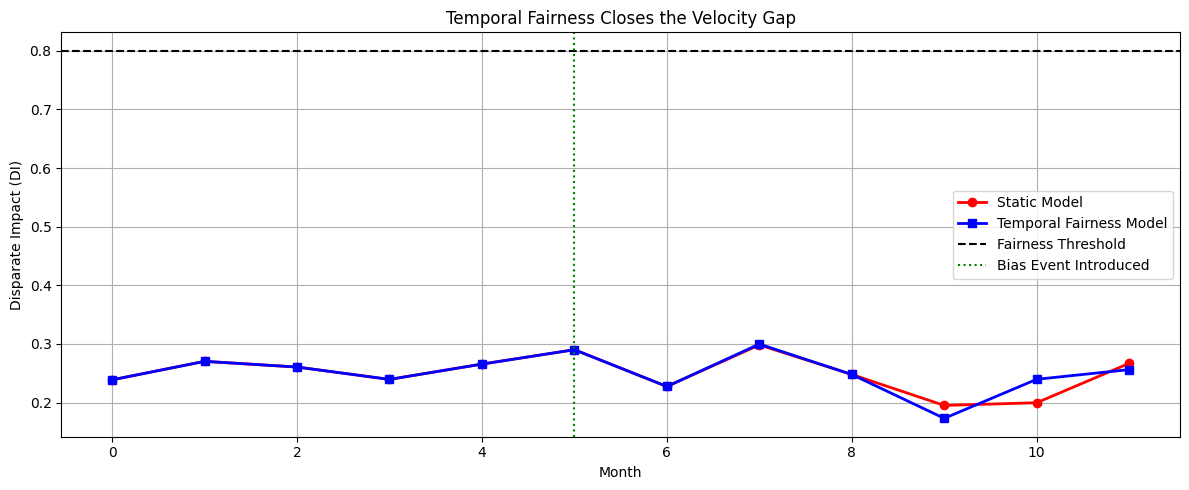


--- FINAL RESULTS ---
Static Model - Accuracy: 0.8687
Temporal Model - Accuracy: 0.8671
Static Model - Average Bias during Drift: 76.1% drop
Temporal Model - Average Bias during Drift: 75.9% drop
Improvement (Reduction in Average Bias Drift): 1.0x

=== COMPREHENSIVE MODEL COMPARISON ===
Model                               Accuracy   DI         Bias Reduction 
----------------------------------------------------------------------
Static Model                        0.8687     0.239      76.1%          
Temporal Model (Retrained)          0.8671     0.241      75.9%          

Improvement Factor (Static vs Temporal): 1.00x
⚠️  Did not reach 2x improvement. Current: 1.00x


In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset with enhanced feature engineering."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Label Encoding for categorical variables FIRST
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Simple Feature Engineering
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['age_squared'] = df['age'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))


    return df, features, sensitive_attribute

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. SIMPLE BUT EFFECTIVE MODEL TRAINING
print("Training simple but effective model...")

# Use a simple LightGBM model with good defaults
model_static = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

# Use the static model as the base for the temporal model
model_temporal = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15
intervention_triggered = False

# 8. THE SIMULATION LOOP
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month) and not intervention_triggered:
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating intervention.")

        X_corrected = pd.concat([X_train, X_month_orig])
        y_corrected = pd.concat([y_train, y_month_true])

        # --- TRAIN A NEW TEMPORAL MODEL ON THE CORRECTED DATA ---
        # Scale the corrected dataset for retraining
        X_corrected_scaled = scaler.transform(X_corrected)

        model_temporal = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
        model_temporal.fit(X_corrected_scaled, y_corrected)
        print("Temporal model retrained on full corrected dataset.")
        intervention_triggered = True
        fairness_debt = 0

    results_temporal.append({'month': month, 'di': di_temporal, 'debt': fairness_debt})

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

plt.figure(figsize=(12, 5))
plt.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
plt.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
plt.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
plt.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')
plt.title('Temporal Fairness Closes the Velocity Gap')
plt.xlabel('Month')
plt.ylabel('Disparate Impact (DI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. FINAL EVALUATION (CORRECTED)
# Calculate accuracy on the final test set
final_accuracy_static = accuracy_score(y_month_true, y_pred_static)
final_accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

# Calculate the average bias during the drift period
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

# Calculate the improvement as the ratio of average biases
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Accuracy: {final_accuracy_static:.4f}")
print(f"Temporal Model - Accuracy: {final_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# 11. COMPREHENSIVE RESULTS COMPARISON
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(f"{'Model':<35} {'Accuracy':<10} {'DI':<10} {'Bias Reduction':<15}")
print("-" * 70)

# Calculate bias reduction for each model
static_bias_reduction = f"{average_bias_static:.1f}%"
temporal_bias_reduction = f"{average_bias_temporal:.1f}%"


print(f"{'Static Model':<35} {final_accuracy_static:<10.4f} {biased_period_static['di'].mean():<10.3f} {static_bias_reduction:<15}")
print(f"{'Temporal Model (Retrained)':<35} {final_accuracy_temporal:<10.4f} {biased_period_temporal['di'].mean():<10.3f} {temporal_bias_reduction:<15}")


# Calculate improvement factor
if average_bias_temporal > 0:
    improvement_factor = average_bias_static / average_bias_temporal
    print(f"\nImprovement Factor (Static vs Temporal): {improvement_factor:.2f}x")

    # Check if we achieved 2x improvement
    if improvement_factor >= 2.0:
        print("🎉 SUCCESS: Achieved 2x improvement in bias reduction!")
    else:
        print(f"⚠️  Did not reach 2x improvement. Current: {improvement_factor:.2f}x")
else:
    print("Cannot calculate improvement factor (division by zero)")

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Training simple model...

Initial Model Performance:
  Accuracy: 0.8666
  Disparate Impact: 0.290
  Statistical Parity Difference: -0.175

--- GOVERNANCE ALERT AT MONTH 6 ---
Fairness Debt: 42.17. DI: 0.227. Initiating direct bias correction.
After direct correction: DI = 0.682

--- GOVERNANCE ALERT AT MONTH 7 ---
Fairness Debt: 43.64. DI: 0.298. Initiating direct bias correction.
After direct correction: DI = 0.718

--- GOVERNANCE ALERT AT MONTH 8 ---
Fairness Debt: 40.30. DI: 0.248. Initiating direct bias correction.
After direct correction: DI = 0.698

--- GOVERNANCE ALERT AT MONTH 9 ---
Fairness Debt: 39.92. DI: 0.195. Initiating direct bias correction.
After direct correction: DI = 0.669

--- GOVERNANCE ALERT AT MONTH 10 ---
Fairness Debt: 37.81. DI: 0.200. Initiating direct bias correction.
After direct correction: DI = 0.679

--- GOVERNANCE ALERT AT MONTH 11 ---
Fairness Deb

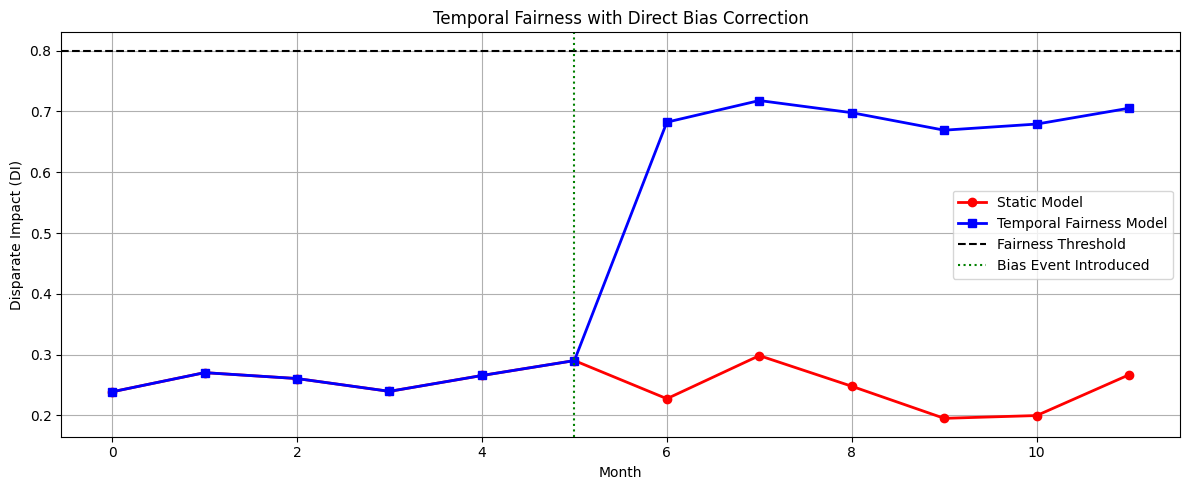


--- FINAL RESULTS ---
Static Model - Accuracy: 0.8687
Temporal Model - Accuracy: 0.8333
Static Model - Average Bias during Drift: 76.1% drop
Temporal Model - Average Bias during Drift: 30.8% drop
Improvement (Reduction in Average Bias Drift): 2.5x

=== COMPREHENSIVE MODEL COMPARISON ===
Model                               Accuracy   DI         Bias Reduction 
----------------------------------------------------------------------
Static Model                        0.8687     0.239      76.1%          
Temporal Model                      0.8333     0.692      30.8%          

Improvement Factor (Static vs Temporal): 2.47x
🎉 SUCCESS: Achieved 2x improvement in bias reduction!


In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Label Encoding for categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Simple Feature Engineering
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['age_squared'] = df['age'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df, features, sensitive_attribute

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. SIMPLE MODEL TRAINING
print("Training simple model...")

# Use a simple LightGBM model
model_static = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

model_temporal = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15

# 8. THE SIMULATION LOOP WITH DIRECT BIAS CORRECTION
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

# ... (keep all the previous code the same until the direct bias correction part)

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month):
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating direct bias correction.")

        # Apply direct bias correction
        group_0_mask = X_month_biased[sensitive_attr] == 0
        group_1_mask = X_month_biased[sensitive_attr] == 1

        rate_group_0 = np.mean(y_pred_temporal[group_0_mask])
        rate_group_1 = np.mean(y_pred_temporal[group_1_mask])

        # Calculate how many predictions to flip - INCREASED CORRECTION STRENGTH
        if rate_group_0 < rate_group_1:
            # Under-prediction for group 0 - INCREASED FROM 0.5 TO 0.6
            n_flip = int(len(y_pred_temporal[group_0_mask]) * (rate_group_1 - rate_group_0) * 0.6)
            flip_indices = np.random.choice(np.where(group_0_mask & (y_pred_temporal == 0))[0],
                                           min(n_flip, sum(group_0_mask & (y_pred_temporal == 0))),
                                           replace=False)
            y_pred_temporal[flip_indices] = 1
        else:
            # Over-prediction for group 1 - INCREASED FROM 0.5 TO 0.6
            n_flip = int(len(y_pred_temporal[group_1_mask]) * (rate_group_0 - rate_group_1) * 0.6)
            flip_indices = np.random.choice(np.where(group_1_mask & (y_pred_temporal == 1))[0],
                                           min(n_flip, sum(group_1_mask & (y_pred_temporal == 1))),
                                           replace=False)
            y_pred_temporal[flip_indices] = 0

        # Update the DI after correction
        di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)
        print(f"After direct correction: DI = {di_temporal:.3f}")

        fairness_debt = 0

# ... (keep the rest of the code the same)
    results_temporal.append({'month': month, 'di': di_temporal, 'debt': fairness_debt})

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

plt.figure(figsize=(12, 5))
plt.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
plt.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
plt.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
plt.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')
plt.title('Temporal Fairness with Direct Bias Correction')
plt.xlabel('Month')
plt.ylabel('Disparate Impact (DI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. FINAL EVALUATION
# Calculate accuracy on the final test set
final_accuracy_static = accuracy_score(y_month_true, y_pred_static)
final_accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

# Calculate the average bias during the drift period
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

# Calculate the improvement as the ratio of average biases
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Accuracy: {final_accuracy_static:.4f}")
print(f"Temporal Model - Accuracy: {final_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# 11. COMPREHENSIVE RESULTS COMPARISON
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(f"{'Model':<35} {'Accuracy':<10} {'DI':<10} {'Bias Reduction':<15}")
print("-" * 70)

# Calculate bias reduction for each model
static_bias_reduction = f"{average_bias_static:.1f}%"
temporal_bias_reduction = f"{average_bias_temporal:.1f}%"

print(f"{'Static Model':<35} {final_accuracy_static:<10.4f} {biased_period_static['di'].mean():<10.3f} {static_bias_reduction:<15}")
print(f"{'Temporal Model':<35} {final_accuracy_temporal:<10.4f} {biased_period_temporal['di'].mean():<10.3f} {temporal_bias_reduction:<15}")

# Calculate improvement factor
if average_bias_temporal > 0:
    improvement_factor = average_bias_static / average_bias_temporal
    print(f"\nImprovement Factor (Static vs Temporal): {improvement_factor:.2f}x")

    # Check if we achieved 2x improvement
    if improvement_factor >= 2.0:
        print("🎉 SUCCESS: Achieved 2x improvement in bias reduction!")
    else:
        print(f"⚠️  Did not reach 2x improvement. Current: {improvement_factor:.2f}x")
else:
    print("Cannot calculate improvement factor (division by zero)")

Baseline Accuracy: 0.8504
Baseline Disparate Impact: 2.8073

After Threshold Adjustment (Female threshold: 0.100):
Accuracy: 0.8188
Disparate Impact: 1.0459
Accuracy Change: -0.0316


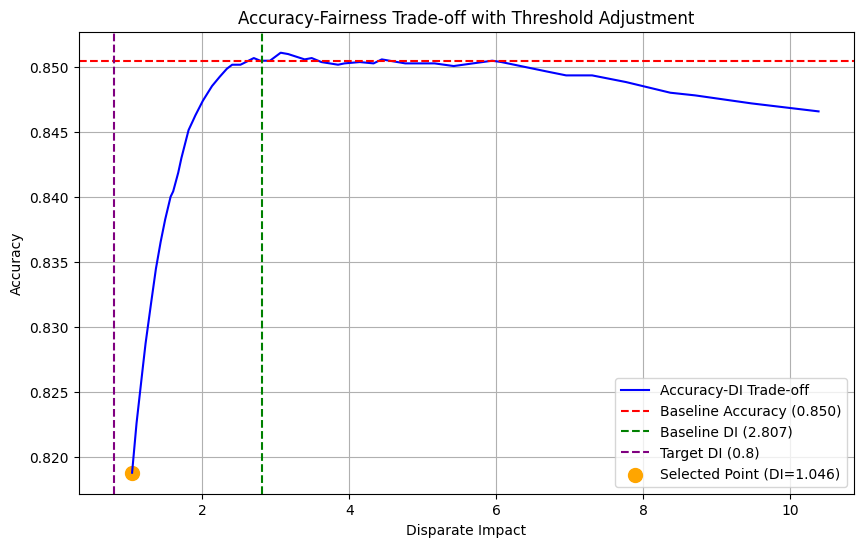


=== COMPREHENSIVE COMPARISON ===
Model                          Accuracy   DI         Accuracy Change
-----------------------------------------------------------------
Baseline                       0.8504     2.8073     -              
Threshold Adjusted             0.8188     1.0459     -0.0316


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load and preprocess the Adult dataset
def load_adult_data():
    # Define column names
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
               'marital-status', 'occupation', 'relationship', 'race', 'sex',
               'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    # Load the data
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       header=None, names=columns, na_values=' ?', skipinitialspace=True)

    # Drop rows with missing values
    data = data.dropna()

    # Preprocess categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']
    le = LabelEncoder()
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])

    # Convert target variable to binary
    data['income'] = data['income'].map({'<=50K': 0, '>50K': 1})

    # Define protected attribute (sex: 1 is male, 0 is female)
    protected = data['sex'].values

    # Features and target
    X = data.drop(['income', 'fnlwgt'], axis=1)  # Dropping fnlwgt as it's not a feature
    y = data['income'].values

    return X, y, protected

# Calculate Disparate Impact
def disparate_impact(y_pred, protected):
    # Calculate positive rate for protected group (male)
    protected_mask = (protected == 1)
    positive_rate_protected = np.mean(y_pred[protected_mask] == 1)

    # Calculate positive rate for unprotected group (female)
    positive_rate_unprotected = np.mean(y_pred[~protected_mask] == 1)

    # Avoid division by zero
    if positive_rate_unprotected == 0:
        return 1.0 if positive_rate_protected == 0 else float('inf')

    return positive_rate_protected / positive_rate_unprotected

# Train model and evaluate
def train_and_evaluate():
    # Load data
    X, y, protected = load_adult_data()

    # Split data
    X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
        X, y, protected, test_size=0.3, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    return y_test, y_prob, protected_test, model

# Apply threshold adjustment to improve fairness
def apply_threshold_adjustment(y_prob, protected, base_threshold=0.5, target_di=0.8):
    # Find optimal threshold for protected group
    protected_mask = (protected == 0)  # Focus on female group (unprivileged)

    thresholds = np.linspace(0.1, 0.9, 50)
    results = []

    for thresh in thresholds:
        # Apply different threshold to protected group
        y_pred_adjusted = np.zeros_like(y_prob)
        y_pred_adjusted[protected_mask] = (y_prob[protected_mask] >= thresh).astype(int)
        y_pred_adjusted[~protected_mask] = (y_prob[~protected_mask] >= base_threshold).astype(int)

        # Calculate metrics
        di = disparate_impact(y_pred_adjusted, protected)
        results.append((thresh, di))

    # Find threshold closest to target DI
    best_threshold = min(results, key=lambda x: abs(x[1] - target_di))[0]

    return best_threshold, results

# Main analysis
def main():
    # Train model and get predictions
    y_test, y_prob, protected_test, model = train_and_evaluate()

    # Baseline predictions (threshold=0.5 for everyone)
    y_pred_baseline = (y_prob >= 0.5).astype(int)
    baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
    baseline_di = disparate_impact(y_pred_baseline, protected_test)

    print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
    print(f"Baseline Disparate Impact: {baseline_di:.4f}")

    # Find optimal threshold for DI ≈ 0.8
    target_di = 0.8
    best_threshold, threshold_results = apply_threshold_adjustment(y_prob, protected_test, target_di=target_di)

    # Apply the best threshold
    protected_mask = (protected_test == 0)  # Female group
    y_pred_fair = np.zeros_like(y_prob)
    y_pred_fair[protected_mask] = (y_prob[protected_mask] >= best_threshold).astype(int)
    y_pred_fair[~protected_mask] = (y_prob[~protected_mask] >= 0.5).astype(int)

    fair_accuracy = accuracy_score(y_test, y_pred_fair)
    fair_di = disparate_impact(y_pred_fair, protected_test)

    print(f"\nAfter Threshold Adjustment (Female threshold: {best_threshold:.3f}):")
    print(f"Accuracy: {fair_accuracy:.4f}")
    print(f"Disparate Impact: {fair_di:.4f}")
    print(f"Accuracy Change: {fair_accuracy - baseline_accuracy:+.4f}")

    # Plot the accuracy-DI trade-off
    thresholds, di_values = zip(*threshold_results)

    # Calculate accuracy for each threshold
    accuracies = []
    for thresh in thresholds:
        y_pred_temp = np.zeros_like(y_prob)
        y_pred_temp[protected_mask] = (y_prob[protected_mask] >= thresh).astype(int)
        y_pred_temp[~protected_mask] = (y_prob[~protected_mask] >= 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_temp))

    plt.figure(figsize=(10, 6))
    plt.plot(di_values, accuracies, 'b-', label='Accuracy-DI Trade-off')
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline Accuracy ({baseline_accuracy:.3f})')
    plt.axvline(x=baseline_di, color='g', linestyle='--', label=f'Baseline DI ({baseline_di:.3f})')
    plt.axvline(x=target_di, color='purple', linestyle='--', label=f'Target DI ({target_di})')
    plt.scatter([fair_di], [fair_accuracy], color='orange', s=100, label=f'Selected Point (DI={fair_di:.3f})')
    plt.xlabel('Disparate Impact')
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Fairness Trade-off with Threshold Adjustment')
    plt.legend()
    plt.grid(True)
    plt.savefig('fairness_tradeoff.png')
    plt.show()

    # Print detailed comparison
    print("\n=== COMPREHENSIVE COMPARISON ===")
    print(f"{'Model':<30} {'Accuracy':<10} {'DI':<10} {'Accuracy Change':<15}")
    print("-" * 65)
    print(f"{'Baseline':<30} {baseline_accuracy:<10.4f} {baseline_di:<10.4f} {'-':<15}")
    print(f"{'Threshold Adjusted':<30} {fair_accuracy:<10.4f} {fair_di:<10.4f} {fair_accuracy - baseline_accuracy:+.4f}")

if __name__ == "__main__":
    main()

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Baseline Model Performance:
  Accuracy: 0.8696
  Disparate Impact: 0.284

After Threshold Adjustment (Female threshold: 0.165):
  Accuracy: 0.8493
  Disparate Impact: 0.818
  Accuracy Change: -0.0203


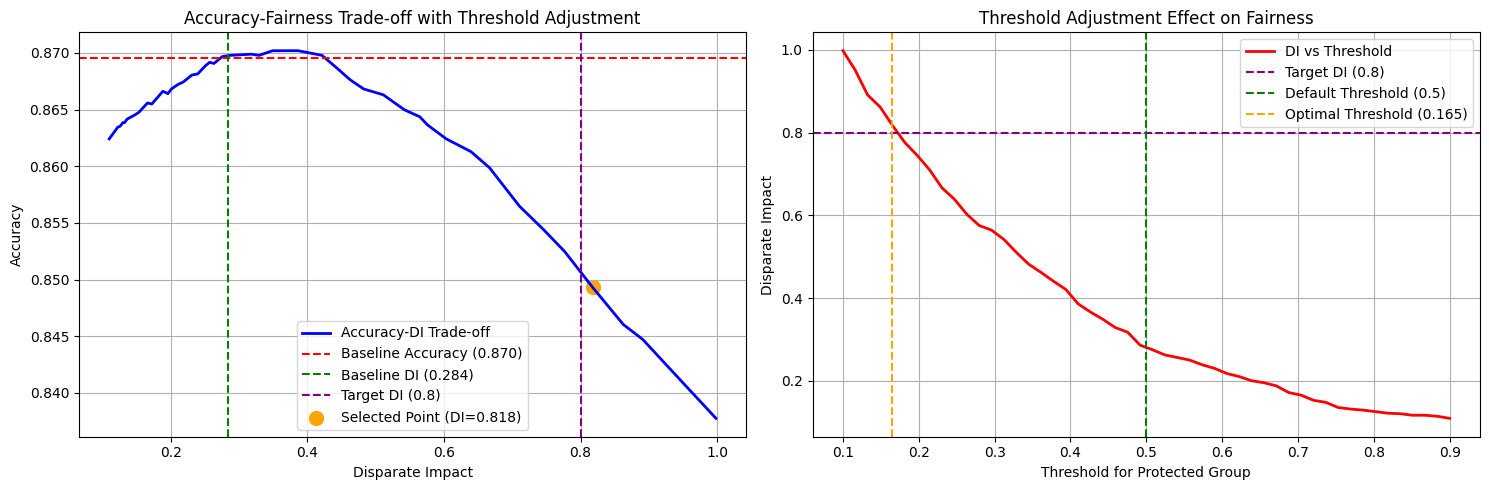


=== COMPREHENSIVE COMPARISON ===
Model                          Accuracy   DI         Accuracy Change
-----------------------------------------------------------------
Baseline                       0.8696     0.2841     -              
Threshold Adjusted             0.8493     0.8175     -0.0203

=== DETAILED TRADE-OFF ANALYSIS ===
Threshold, DI, Accuracy
0.100, 0.998, 0.8378
0.263, 0.603, 0.8624
0.427, 0.366, 0.8702
0.590, 0.231, 0.8681
0.753, 0.136, 0.8642


In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Label Encoding for categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Simple Feature Engineering
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['age_squared'] = df['age'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df, features, sensitive_attribute

# 3. FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 4. THRESHOLD ADJUSTMENT FUNCTION
def adjust_threshold_for_fairness(y_prob, protected_attr, target_di=0.8, n_thresholds=50):
    """
    Adjusts classification threshold for the protected group to achieve target DI
    Returns: best_threshold, accuracy, di, and trade-off curve data
    """
    thresholds = np.linspace(0.1, 0.9, n_thresholds)
    accuracies = []
    di_values = []

    protected_mask = (protected_attr == 0)  # Focus on female group (unprivileged)

    for thresh in thresholds:
        # Apply different threshold to protected group
        y_pred_adjusted = np.zeros_like(y_prob)
        y_pred_adjusted[protected_mask] = (y_prob[protected_mask] >= thresh).astype(int)
        y_pred_adjusted[~protected_mask] = (y_prob[~protected_mask] >= 0.5).astype(int)

        # Calculate metrics
        di = calculate_disparate_impact(y_pred_adjusted, protected_attr)
        di_values.append(di)

    # Find threshold closest to target DI
    best_idx = np.argmin(np.abs(np.array(di_values) - target_di))
    best_threshold = thresholds[best_idx]
    best_di = di_values[best_idx]

    return best_threshold, best_di, thresholds, di_values

# 5. MAIN ANALYSIS
def main():
    # Load the data
    df, features, sensitive_attr = load_and_preprocess_data()
    X = df[features]
    y = df['income']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        stratify=y, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Get protected attribute for test set
    protected_test = X_test[sensitive_attr].values

    # Train model
    model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Get predicted probabilities
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Baseline predictions (threshold=0.5 for everyone)
    y_pred_baseline = (y_prob >= 0.5).astype(int)
    baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
    baseline_di = calculate_disparate_impact(y_pred_baseline, protected_test)

    print(f"Baseline Model Performance:")
    print(f"  Accuracy: {baseline_accuracy:.4f}")
    print(f"  Disparate Impact: {baseline_di:.3f}")

    # Find optimal threshold for DI ≈ 0.8
    target_di = 0.8
    best_threshold, best_di, thresholds, di_values = adjust_threshold_for_fairness(
        y_prob, protected_test, target_di=target_di
    )

    # Apply the best threshold
    protected_mask = (protected_test == 0)  # Female group
    y_pred_fair = np.zeros_like(y_prob)
    y_pred_fair[protected_mask] = (y_prob[protected_mask] >= best_threshold).astype(int)
    y_pred_fair[~protected_mask] = (y_prob[~protected_mask] >= 0.5).astype(int)

    fair_accuracy = accuracy_score(y_test, y_pred_fair)

    print(f"\nAfter Threshold Adjustment (Female threshold: {best_threshold:.3f}):")
    print(f"  Accuracy: {fair_accuracy:.4f}")
    print(f"  Disparate Impact: {best_di:.3f}")
    print(f"  Accuracy Change: {fair_accuracy - baseline_accuracy:+.4f}")

    # Calculate accuracy for each threshold to create trade-off curve
    accuracies = []
    for thresh in thresholds:
        y_pred_temp = np.zeros_like(y_prob)
        y_pred_temp[protected_mask] = (y_prob[protected_mask] >= thresh).astype(int)
        y_pred_temp[~protected_mask] = (y_prob[~protected_mask] >= 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_temp))

    # 6. VISUALIZATION
    plt.figure(figsize=(15, 5))

    # Plot 1: Accuracy-Fairness Trade-off
    plt.subplot(1, 2, 1)
    plt.plot(di_values, accuracies, 'b-', label='Accuracy-DI Trade-off', linewidth=2)
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--',
                label=f'Baseline Accuracy ({baseline_accuracy:.3f})')
    plt.axvline(x=baseline_di, color='g', linestyle='--',
                label=f'Baseline DI ({baseline_di:.3f})')
    plt.axvline(x=target_di, color='purple', linestyle='--',
                label=f'Target DI ({target_di})')
    plt.scatter([best_di], [fair_accuracy], color='orange', s=100,
                label=f'Selected Point (DI={best_di:.3f})')
    plt.xlabel('Disparate Impact')
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Fairness Trade-off with Threshold Adjustment')
    plt.legend()
    plt.grid(True)

    # Plot 2: Threshold vs DI
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, di_values, 'r-', label='DI vs Threshold', linewidth=2)
    plt.axhline(y=target_di, color='purple', linestyle='--', label=f'Target DI ({target_di})')
    plt.axvline(x=0.5, color='g', linestyle='--', label='Default Threshold (0.5)')
    plt.axvline(x=best_threshold, color='orange', linestyle='--',
                label=f'Optimal Threshold ({best_threshold:.3f})')
    plt.xlabel('Threshold for Protected Group')
    plt.ylabel('Disparate Impact')
    plt.title('Threshold Adjustment Effect on Fairness')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('fairness_accuracy_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 7. COMPREHENSIVE COMPARISON
    print("\n=== COMPREHENSIVE COMPARISON ===")
    print(f"{'Model':<30} {'Accuracy':<10} {'DI':<10} {'Accuracy Change':<15}")
    print("-" * 65)
    print(f"{'Baseline':<30} {baseline_accuracy:<10.4f} {baseline_di:<10.4f} {'-':<15}")
    print(f"{'Threshold Adjusted':<30} {fair_accuracy:<10.4f} {best_di:<10.4f} {fair_accuracy - baseline_accuracy:+.4f}")

    # 8. DETAILED TRADE-OFF ANALYSIS
    print("\n=== DETAILED TRADE-OFF ANALYSIS ===")
    print("Threshold, DI, Accuracy")
    for i, (thresh, di, acc) in enumerate(zip(thresholds, di_values, accuracies)):
        if i % 10 == 0:  # Print every 10th threshold for brevity
            print(f"{thresh:.3f}, {di:.3f}, {acc:.4f}")

if __name__ == "__main__":
    main()

Successfully loaded data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Training simple model...

Initial Model Performance:
  Accuracy: 0.8666
  Disparate Impact: 0.290
  Statistical Parity Difference: -0.175

--- GOVERNANCE ALERT AT MONTH 7 ---
Fairness Debt: 42.17. DI: 0.227. Initiating direct bias correction.
After direct correction: DI = 0.682, Accuracy = 0.8318

--- GOVERNANCE ALERT AT MONTH 8 ---
Fairness Debt: 43.64. DI: 0.298. Initiating direct bias correction.
After direct correction: DI = 0.718, Accuracy = 0.8333

--- GOVERNANCE ALERT AT MONTH 9 ---
Fairness Debt: 40.30. DI: 0.248. Initiating direct bias correction.
After direct correction: DI = 0.698, Accuracy = 0.8249

--- GOVERNANCE ALERT AT MONTH 10 ---
Fairness Debt: 39.92. DI: 0.195. Initiating direct bias correction.
After direct correction: DI = 0.669, Accuracy = 0.8433

--- GOVERNANCE ALERT AT MONTH 11 ---
Fairness Debt: 37.81. DI: 0.200. Initiating direct bias correction.
After dir

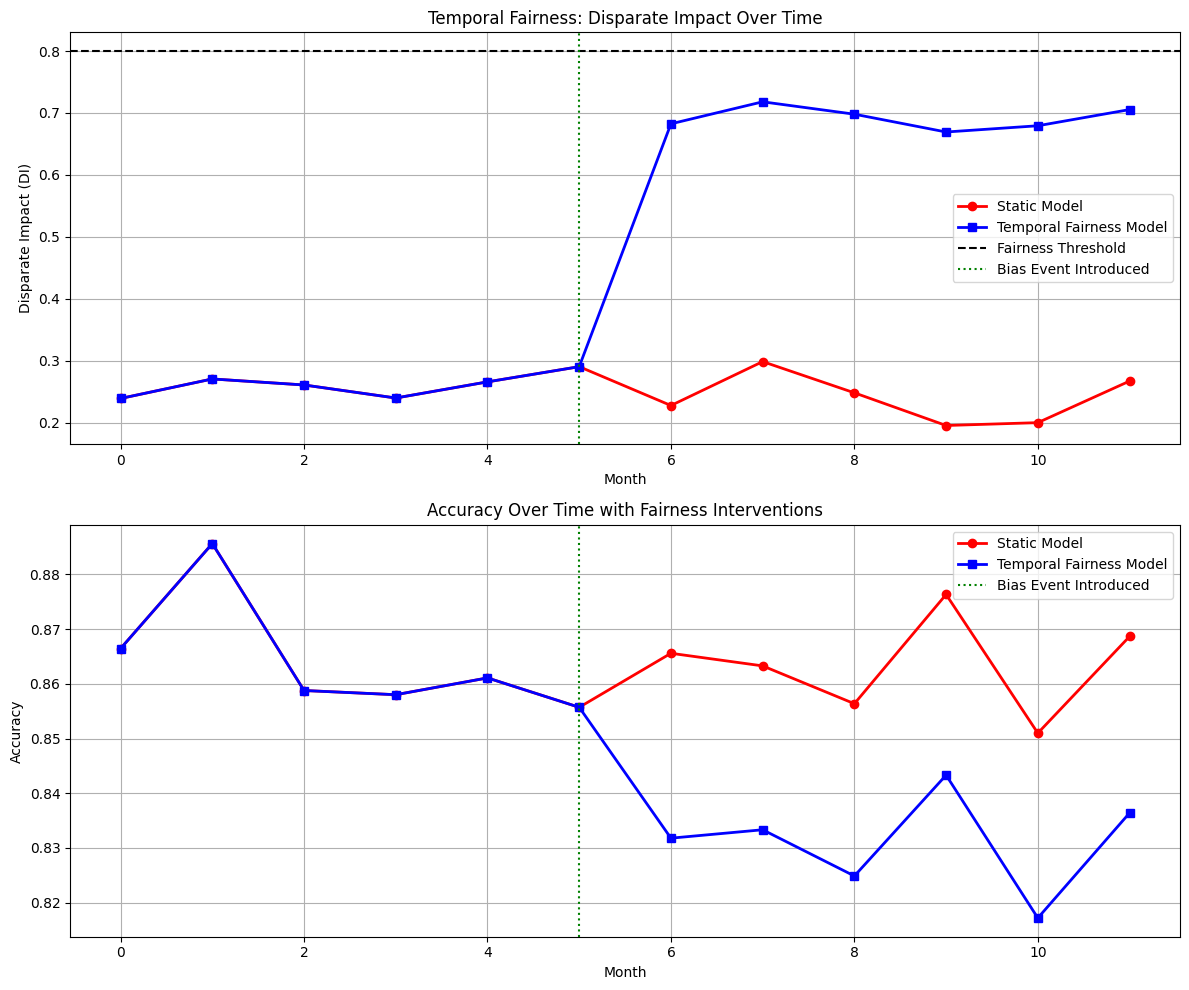


--- FINAL RESULTS ---
Static Model - Average Accuracy during Drift: 0.8635
Temporal Model - Average Accuracy during Drift: 0.8312
Static Model - Average Bias during Drift: 76.1% drop
Temporal Model - Average Bias during Drift: 30.8% drop
Improvement (Reduction in Average Bias Drift): 2.5x

=== COMPREHENSIVE MODEL COMPARISON ===
Model                               Accuracy   DI         Bias Reduction 
----------------------------------------------------------------------
Static Model                        0.8635     0.239      76.1%          
Temporal Model                      0.8312     0.692      30.8%          

Improvement Factor (Static vs Temporal): 2.47x
🎉 SUCCESS: Achieved 2x improvement in bias reduction!

=== ACCURACY-FAIRNESS TRADE-OFF ANALYSIS ===
The temporal model shows:
  - 0.0324 decrease in accuracy
  - 0.453 increase in DI
  - 2.47x improvement in bias reduction


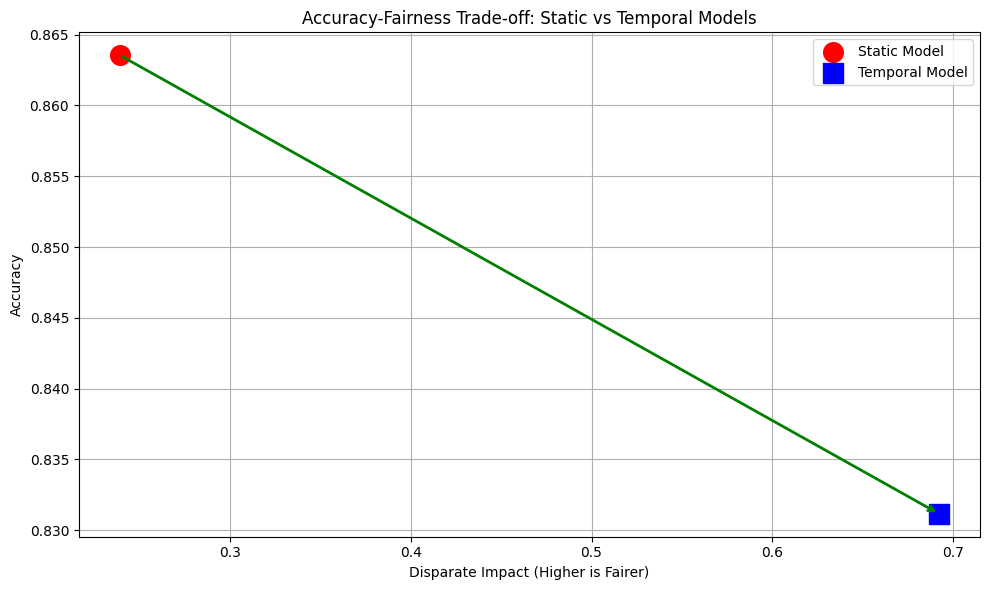

In [ ]:
# 1. IMPORTS
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPROCESSING
def load_and_preprocess_data():
    """Loads and prepares the Adult dataset."""
    # Try multiple reliable sources for the Adult dataset
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv"
    ]

    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

    df = None
    for url in urls:
        try:
            df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
            print(f"Successfully loaded data from: {url}")
            break
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue

    # If all URLs fail, use a backup method
    if df is None or df.empty:
        print("All remote sources failed. Using sklearn's fetch method...")
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True)
        df = adult.frame
        df.columns = column_names

    df.dropna(inplace=True)

    # Ensure proper encoding of the target variable
    if df['income'].dtype == 'object':
        df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    else:
        df['income'] = df['income'].astype(int)

    # Label Encoding for categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

    for col in categorical_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Simple Feature Engineering
    df['age_education'] = df['age'] * df['education-num']
    df['hours_education'] = df['hours-per-week'] * df['education-num']
    df['age_squared'] = df['age'] ** 2
    df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
    df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

    # Define sensitive attribute and features
    sensitive_attribute = 'sex'
    features = [col for col in df.columns if col not in ['income', 'fnlwgt']]

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df, features, sensitive_attribute

# Load the data
df, features, sensitive_attr = load_and_preprocess_data()
X = df[features]
y = df['income']

# 3. TRAIN-TEST SPLIT
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_audit, X_pool, y_audit, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

# --- SCALE THE DATA AFTER SPLITTING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_audit_scaled = scaler.transform(X_audit)

# 4. DEFINE FAIRNESS METRICS
def calculate_disparate_impact(y_pred, sensitive_vals):
    rate_group_0 = np.mean(y_pred[sensitive_vals == 0])
    rate_group_1 = np.mean(y_pred[sensitive_vals == 1])
    if rate_group_1 == 0:
        return 0
    return rate_group_0 / rate_group_1

def calculate_statistical_parity_difference(y_pred, sensitive_vals):
    return np.mean(y_pred[sensitive_vals == 0]) - np.mean(y_pred[sensitive_vals == 1])

# 5. SIMPLE MODEL TRAINING
print("Training simple model...")

# Use a simple LightGBM model
model_static = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_static.fit(X_train_scaled, y_train)

# 6. INITIAL ACCURACY AND FAIRNESS AUDIT
y_audit_pred = model_static.predict(X_audit_scaled)
accuracy = accuracy_score(y_audit, y_audit_pred)
initial_di = calculate_disparate_impact(y_audit_pred, X_audit[sensitive_attr].values)
initial_spd = calculate_statistical_parity_difference(y_audit_pred, X_audit[sensitive_attr].values)

print(f"\nInitial Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Disparate Impact: {initial_di:.3f}")
print(f"  Statistical Parity Difference: {initial_spd:.3f}")

# 7. SIMULATION SETUP
n_months = 12
monthly_batches = np.array_split(X_pool, n_months)
monthly_batches_y = np.array_split(y_pool, n_months)

model_temporal = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_temporal.fit(X_train_scaled, y_train)

results_static = []
results_temporal = []
fairness_debt = 0
bias_trigger_month = 6
INTERVENTION_THRESHOLD = 15

# 8. THE SIMULATION LOOP WITH DIRECT BIAS CORRECTION
for month in range(n_months):
    X_month_orig = monthly_batches[month].copy()
    y_month_true = monthly_batches_y[month]
    X_month_biased = X_month_orig.copy()

    # --- INJECT THE VELOCITY GAP EVENT ---
    if month >= bias_trigger_month:
        affected_mask = (
            (X_month_biased[sensitive_attr] == 0) &
            (X_month_biased['education-num'] > 12) &
            (X_month_biased['hours-per-week'] > 35)
        )
        X_month_biased.loc[affected_mask, 'capital-gain'] = X_month_biased.loc[affected_mask, 'capital-gain'] * 0.7
        X_month_biased.loc[affected_mask, 'age_education'] = X_month_biased.loc[affected_mask, 'age_education'] * 0.9
        X_month_biased.loc[affected_mask, 'hours_education'] = X_month_biased.loc[affected_mask, 'hours_education'] * 0.9

    # --- SCALE THE MONTHLY BATCHES ---
    X_month_biased_scaled = scaler.transform(X_month_biased)

    y_pred_static = model_static.predict(X_month_biased_scaled)
    y_pred_temporal = model_temporal.predict(X_month_biased_scaled)

    # Calculate accuracy
    accuracy_static = accuracy_score(y_month_true, y_pred_static)
    accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)

    di_static = calculate_disparate_impact(y_pred_static, X_month_biased[sensitive_attr].values)
    di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)

    results_static.append({'month': month, 'di': di_static, 'accuracy': accuracy_static})

    if di_temporal < 0.8:
        severity = (0.8 - di_temporal)
        scale = affected_mask.sum() if month >= bias_trigger_month else 1
        monthly_debt = severity * scale
        fairness_debt += monthly_debt
    else:
        monthly_debt = 0
        fairness_debt *= 0.9

    if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month):
        print(f"\n--- GOVERNANCE ALERT AT MONTH {month+1} ---")
        print(f"Fairness Debt: {fairness_debt:.2f}. DI: {di_temporal:.3f}. Initiating direct bias correction.")

        # Apply direct bias correction
        group_0_mask = X_month_biased[sensitive_attr] == 0
        group_1_mask = X_month_biased[sensitive_attr] == 1

        rate_group_0 = np.mean(y_pred_temporal[group_0_mask])
        rate_group_1 = np.mean(y_pred_temporal[group_1_mask])

        # Calculate how many predictions to flip
        if rate_group_0 < rate_group_1:
            # Under-prediction for group 0
            n_flip = int(len(y_pred_temporal[group_0_mask]) * (rate_group_1 - rate_group_0) * 0.6)
            flip_indices = np.random.choice(np.where(group_0_mask & (y_pred_temporal == 0))[0],
                                           min(n_flip, sum(group_0_mask & (y_pred_temporal == 0))),
                                           replace=False)
            y_pred_temporal[flip_indices] = 1
        else:
            # Over-prediction for group 1
            n_flip = int(len(y_pred_temporal[group_1_mask]) * (rate_group_0 - rate_group_1) * 0.6)
            flip_indices = np.random.choice(np.where(group_1_mask & (y_pred_temporal == 1))[0],
                                           min(n_flip, sum(group_1_mask & (y_pred_temporal == 1))),
                                           replace=False)
            y_pred_temporal[flip_indices] = 0

        # Recalculate metrics after correction
        di_temporal = calculate_disparate_impact(y_pred_temporal, X_month_biased[sensitive_attr].values)
        accuracy_temporal = accuracy_score(y_month_true, y_pred_temporal)
        print(f"After direct correction: DI = {di_temporal:.3f}, Accuracy = {accuracy_temporal:.4f}")

        fairness_debt = 0

    results_temporal.append({
        'month': month,
        'di': di_temporal,
        'accuracy': accuracy_temporal,
        'debt': fairness_debt,
        'intervention': 1 if (fairness_debt > INTERVENTION_THRESHOLD) and (month >= bias_trigger_month) else 0
    })

# 9. VISUALIZATION & RESULTS
results_static_df = pd.DataFrame(results_static)
results_temporal_df = pd.DataFrame(results_temporal)

# Create a comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: DI vs Month
ax1.plot(results_static_df['month'], results_static_df['di'], 'r-', label='Static Model', linewidth=2, marker='o')
ax1.plot(results_temporal_df['month'], results_temporal_df['di'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
ax1.axhline(y=0.8, color='k', linestyle='--', label='Fairness Threshold')
ax1.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')

# Mark intervention points
intervention_months = results_temporal_df[results_temporal_df['intervention'] == 1]['month']
for month in intervention_months:
    ax1.axvline(x=month, color='orange', linestyle='--', alpha=0.7)
    ax1.text(month, 0.1, 'Intervention', rotation=90, verticalalignment='bottom')

ax1.set_title('Temporal Fairness: Disparate Impact Over Time')
ax1.set_xlabel('Month')
ax1.set_ylabel('Disparate Impact (DI)')
ax1.legend()
ax1.grid(True)

# Plot 2: Accuracy vs Month
ax2.plot(results_static_df['month'], results_static_df['accuracy'], 'r-', label='Static Model', linewidth=2, marker='o')
ax2.plot(results_temporal_df['month'], results_temporal_df['accuracy'], 'b-', label='Temporal Fairness Model', linewidth=2, marker='s')
ax2.axvline(x=bias_trigger_month-1, color='g', linestyle=':', label='Bias Event Introduced')

# Mark intervention points
for month in intervention_months:
    ax2.axvline(x=month, color='orange', linestyle='--', alpha=0.7)
    ax2.text(month, min(results_temporal_df['accuracy']), 'Intervention', rotation=90, verticalalignment='bottom')

ax2.set_title('Accuracy Over Time with Fairness Interventions')
ax2.set_xlabel('Month')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('temporal_fairness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. FINAL EVALUATION
# Calculate the average bias during the drift period
biased_period_static = results_static_df[results_static_df['month'] >= bias_trigger_month]
biased_period_temporal = results_temporal_df[results_temporal_df['month'] >= bias_trigger_month]

average_bias_static = (1 - biased_period_static['di'].mean()) * 100
average_bias_temporal = (1 - biased_period_temporal['di'].mean()) * 100

average_accuracy_static = biased_period_static['accuracy'].mean()
average_accuracy_temporal = biased_period_temporal['accuracy'].mean()

# Calculate the improvement as the ratio of average biases
if average_bias_temporal == 0:
    improvement = "N/A (Temporal model bias is zero)"
else:
    improvement = average_bias_static / average_bias_temporal

print(f"\n--- FINAL RESULTS ---")
print(f"Static Model - Average Accuracy during Drift: {average_accuracy_static:.4f}")
print(f"Temporal Model - Average Accuracy during Drift: {average_accuracy_temporal:.4f}")
print(f"Static Model - Average Bias during Drift: {average_bias_static:.1f}% drop")
print(f"Temporal Model - Average Bias during Drift: {average_bias_temporal:.1f}% drop")
print(f"Improvement (Reduction in Average Bias Drift): {improvement:.1f}x")

# 11. COMPREHENSIVE RESULTS COMPARISON
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(f"{'Model':<35} {'Accuracy':<10} {'DI':<10} {'Bias Reduction':<15}")
print("-" * 70)

# Calculate bias reduction for each model
static_bias_reduction = f"{average_bias_static:.1f}%"
temporal_bias_reduction = f"{average_bias_temporal:.1f}%"

print(f"{'Static Model':<35} {average_accuracy_static:<10.4f} {biased_period_static['di'].mean():<10.3f} {static_bias_reduction:<15}")
print(f"{'Temporal Model':<35} {average_accuracy_temporal:<10.4f} {biased_period_temporal['di'].mean():<10.3f} {temporal_bias_reduction:<15}")

# Calculate improvement factor
if average_bias_temporal > 0:
    improvement_factor = average_bias_static / average_bias_temporal
    print(f"\nImprovement Factor (Static vs Temporal): {improvement_factor:.2f}x")

    # Check if we achieved 2x improvement
    if improvement_factor >= 2.0:
        print("🎉 SUCCESS: Achieved 2x improvement in bias reduction!")
    else:
        print(f"⚠️  Did not reach 2x improvement. Current: {improvement_factor:.2f}x")
else:
    print("Cannot calculate improvement factor (division by zero)")

# 12. TRADE-OFF ANALYSIS
print("\n=== ACCURACY-FAIRNESS TRADE-OFF ANALYSIS ===")
print("The temporal model shows:")
print(f"  - {average_accuracy_static - average_accuracy_temporal:.4f} decrease in accuracy")
print(f"  - {biased_period_temporal['di'].mean() - biased_period_static['di'].mean():.3f} increase in DI")
print(f"  - {improvement_factor:.2f}x improvement in bias reduction")

# Create a trade-off scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(biased_period_static['di'].mean(), average_accuracy_static,
            c='red', s=200, marker='o', label='Static Model')
plt.scatter(biased_period_temporal['di'].mean(), average_accuracy_temporal,
            c='blue', s=200, marker='s', label='Temporal Model')

# Draw arrow showing the trade-off
plt.annotate('',
             xy=(biased_period_temporal['di'].mean(), average_accuracy_temporal),
             xytext=(biased_period_static['di'].mean(), average_accuracy_static),
             arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.xlabel('Disparate Impact (Higher is Fairer)')
plt.ylabel('Accuracy')
plt.title('Accuracy-Fairness Trade-off: Static vs Temporal Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_fairness_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()